In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 3s (3,424 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155222 files and d

실행 후 런타임 재시작

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

# 1.리뷰 크롤링

In [ ]:
#이 부분은 처음 한번만 실행하면 됌.
!pip install selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

     |████████████████████████████████| 958 kB 4.0 MB/s 
     |████████████████████████████████| 356 kB 61.8 MB/s 
     |████████████████████████████████| 138 kB 48.8 MB/s 
     |████████████████████████████████| 55 kB 2.2 MB/s 
     |████████████████████████████████| 3.6 MB 33.6 MB/s 
     |████████████████████████████████| 54 kB 2.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.7 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.down

In [ ]:
from selenium import webdriver
from urllib.request import urlopen
from bs4 import BeautifulSoup 
from urllib.parse import quote_plus
from selenium.webdriver.common.keys import Keys
import time
import pandas as pd
import re
import requests
import numpy as np

pd.set_option('display.max_rows' ,100000)
pd.set_option('max_colwidth',100000)

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [ ]:
class Steam:
    def __init__(self, game_id, cond):
        self.game_id = game_id  # steam game code
        self.cond = cond  # positive or negative only

    def get_review(self):
        options = webdriver.ChromeOptions()
        options.add_argument('--headless')        # Head-less 설정
        options.add_argument('--no-sandbox')
        options.add_argument('--disable-dev-shm-usage')
        browser = webdriver.Chrome('chromedriver', options=options)
        browser.maximize_window()

        # 페이지 이동  
        url = "https://steamcommunity.com/app/" + self.game_id + "/" + \
            self.cond + "reviews/?browsefilter=toprated&p=1&filterLanguage=koreana"
        browser.get(url)

        interval = 2  # 2초에 한번씩 스크롤 다운

        # 현재 문서 높이 가져와서 저장
        prev_height = browser.execute_script(
            "return document.body.scrollHeight")

        # 반복수행
        while True:
            # 스크롤을 가장 아래로 내림
            browser.execute_script(
                "window.scrollTo(0, document.body.scrollHeight)")

        # 페이지 로딩 대기
            time.sleep(interval)

        # 현재 문서 높이를 가져와서 저장
            curr_height = browser.execute_script(
                "return document.body.scrollHeight")
            if curr_height == prev_height:
                break

            prev_height = curr_height
        print("스크롤 완료")

        soup = BeautifulSoup(browser.page_source, "lxml")

        # 리뷰, 플레이타임, 리뷰추천수
        review_box = soup.find_all(
            "div", attrs={"class": "apphub_CardContentMain"})
        print(len(review_box))

        df_review = []
        df_playtime = []
        df_helpful = []
        df_funny = []
        df_game_cnt = []
        df_date_year = []
        df_date_month = []

        year = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
                '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
        month = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
                 'August', 'September', 'October', 'November', 'December']

        for box in review_box:
            review = box.find(
                "div", attrs={"class": "apphub_CardTextContent"}).get_text().strip()
            review = review.replace('Early Access Review', '')
            review = review.replace('Posted: ', '')
            review = review.split()
            if len(review) == 2:
                pass
            else:
                if (review[2] in year):
                    review = ' '.join(review[3:])
                else:
                    review = ' '.join(review[2:])
            df_review.append(review)

            playtime = box.find("div", attrs={"class": "hours"}).get_text()
            playtime = playtime.split()
            temp1 = []
            for w in playtime:
                w = re.sub(r'[^0-9.]', '', w)
                w = "".join([str(_) for _ in w])
                temp1.append(w)
            temp1 = list(filter(None, temp1))
            df_playtime.append(float(temp1[0]))

            recommend = box.find(
                "div", attrs={"class": "found_helpful"}).get_text().strip()
            recommend = recommend.split()
            temp2 = []  # 유용한 평가, 재미있는 평가, 받은 이모티콘 수
            for w in recommend:
                w = re.findall(r'[0-9]+', w)
                w = "".join([str(_) for _ in w])
                temp2.append(w)
            temp2 = list(filter(None, temp2))

            if len(temp2) == 3:
                df_helpful.append(int(temp2[0]))
                df_funny.append(int(temp2[1]))
            elif len(temp2) == 2:
                df_helpful.append(int(temp2[0]))
                df_funny.append(int(temp2[1]))
            elif len(temp2) == 1:
                df_helpful.append(int(temp2[0]))
                df_funny.append(int(0))
            else:
                df_helpful.append(int(0))
                df_funny.append(int(0))

            # 리뷰 게시 일시
            date = box.find("div", attrs={"class": "date_posted"}).get_text()
            date = date.replace('Posted: ', '')
            date = date.replace(',', '')
            date = date.split()
            
            get_i = 0
            for i in range(len(date)):  # 년도 추출
                if date[i] in year:
                    get_i = i
            if get_i:
                df_date_year.append(date[get_i])
            else:
                df_date_year.append(2021)
            
            get_i = 0
            for i in range(len(date)):  # 월 추출
                if date[i] in month:
                    df_date_month.append(date[i])

        # 구매한 게임 수
        games = soup.find_all(
            "div", attrs={"class": "apphub_CardContentAuthorBlock tall"})

        for game in games:
            game_cnt = game.find(
                "div", attrs={"class": "apphub_CardContentMoreLink ellipsis"}).get_text()
            game_cnt = re.sub(r'[^0-9]', '', game_cnt)
            df_game_cnt.append(game_cnt)
            

        final_data = {'리뷰': df_review, "플레이타임": df_playtime,
                      '유용한 평가': df_helpful, '재밌는 평가': df_funny, 
                      '구매게임 수': df_game_cnt, '작성 년도': df_date_year, '작성 월': df_date_month}
        df = pd.DataFrame(final_data)
        
        df['작성 월'] = df['작성 월'].map({'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7,
                 'August':8, 'September':9, 'October':10, 'November':11, 'December':12})

        # positive : 1  / negative : 0
        if self.cond == 'positive':
            df['label'] = 1
        else:
            df['label'] = 0
        return df

In [ ]:
def review_df(code):
  g_pos = Steam(str(code), 'positive')
  g_r_pos = g_pos.get_review()

  g_neg = Steam(str(code), 'negative')
  g_n_pos = g_neg.get_review()

  new_df = pd.concat([g_r_pos, g_n_pos], ignore_index=True)

  shuffle_df = new_df.sample(frac=1).reset_index(drop=True)
  return shuffle_df

## 여기서부터 시작

In [ ]:
temp = review_df(1049410)

스크롤 완료
409
스크롤 완료
19


In [ ]:
temp.head()

,리뷰,플레이타임,유용한 평가,재밌는 평가,구매게임 수,작성 년도,작성 월,label
0,"잘 만들어진 마피아게임류 단, 친구가 있어야 꿀잼 모든 Player에게는 Role(역할)이 주어지며 한쪽 진영의 게임 목표가 달성될 때까지 밤과 낮이 반복된다. 시민 진영의 목표는 늑대인간 진영을 전부 처단하는 것이고, 늑대인간 진영의 목표는 시민 진영을 전부 처단하는 것이다. 그리고 단독 진영 플레이어들은 각자 자신들의 승리 조건을 달성하면 된다.게임이 시작되면 각각의 플레이어게 역할이 부여되며 밤이 찾아오고 첫 턴이 된다. 밤에 능력을 발휘할 수 있는 역할은 이 때 활동할 수 있으며 이 활동은 소녀 역할을 제외한 다른 인원은 볼 수 없다. 날이 밝고 첫 날이 되면 첫 턴의 결과가 나타난다. 그리고 첫 날에 시장을 다수결로 선출한다. 시장 선출이 끝나면 누굴 죽일지 투표하게 된다.투표 후 처형당한 플레이어는 역할이 밝혀지며 바로 밤이 찾아오고 두번째 턴이 된다. 그리고 다시 밤 활동이 시작된다.매일 투표가 진행되며, 의심스러운 플레이어를 다수결로 처치할 수 있다. 그러므로 모든 플레이어들은 자신의 진영 또는 자신에게 유리하도록 게임을 풀어나가야 한다. 하루는 150초동안 지속되며, 모든 플레이어가 투표 대상을 지목했을 때 10초로 시간이 단축된다. 투표 대상은 언제든지 바꿀 수 있으며 취소할 수도 있다.늑대들은 밤중에 40초동안 시민을 골라 죽일 수 있다. 특수 능력을 가진 늑대의 경우에는 자기 능력을 발휘할 수 있는 추가 턴을 얻는다.밤에 사용할 수 있는 능력을 가진 시민들도 추가 턴을 얻는다. 이들의 능력은 어떻게 쓰이느냐에 따라 시민 진영에게 유리하거나 불리하게 작용할 수 있다. 직업목록 시민 진영 시민(Villager) 선견자(Seer) 마녀(Witch) 사냥꾼(Hunter) 영매(Medium) 소녀(Little girl) 큐피드(Cupid) 경비병(Guard) 독재자(Dictator) 조련사(Tamer) 까마귀(Crow) 강령술사(Necromancer) 폭탄광(Blaster)늑대 진영 마취사(Anesthetist) 늑대인간(Werewolf) 안개의 늑대(Misty wolf) 검은늑대(Black wolf)단독 진영 천사(Angel) 인플루언서(Influencer) 암살자(Assassin) 방화광(Pyromaniac) 하얀 늑대(White Wolf)",4.0,0,0,125,2021,6,1
1,인싸겜,8.2,0,0,90,2021,5,1
2,주변 사람들과 함께 했을 때 재밌는 게임 입니다!같이 하실 분 놀러오세요 ~https://discord.gg/DjFZHKe,2.6,1,0,116,2021,5,1
3,재밌어용..다같이할만하고 쉽고 간단하게 할 수 있어서 좋았습니다.,7.0,1,0,78,2020,9,1
4,친구들이랑하면 개유잼,5.9,0,0,21,2021,10,1


# 2.전처리

In [ ]:
df = temp.copy()

### 이모티콘 제거

In [ ]:
df = df.drop(df.index[2592])
df = df.reset_index(drop=True)

In [ ]:
import re

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [ ]:
for i in range(len(df)):
  print(i)
  df['리뷰'][i] = emoji_pattern.sub(r'', df['리뷰'][i])

0
1
2
3
4
5
6
7


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


TypeError: ignored

### 특수문자 제거

In [ ]:
# 특수문자 제거
characters1 = "\\"
characters2 = "\u200b5."
characters3 = "\u200b4."
characters4 = "\u200b" 
characters5 = "\'"
characters6 = '\U0001f7e9'

for i in range(len(df)):
  print(i)
  df['리뷰'][i] = df['리뷰'][i].replace(characters1,"")
  df['리뷰'][i] = df['리뷰'][i].replace(characters2,"")
  df['리뷰'][i] = df['리뷰'][i].replace(characters3,"")
  df['리뷰'][i] = df['리뷰'][i].replace(characters4,"")
  df['리뷰'][i] = df['리뷰'][i].replace(characters5,"")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/l

126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375


### 반복문자 normalization

In [ ]:
!pip install soynlp

     |████████████████████████████████| 416 kB 4.0 MB/s 


In [ ]:
# 반복되는 문자 normalization
from soynlp.normalizer import *

for idx in range(len(df)): 
  df['리뷰'][i] = repeat_normalize(df['리뷰'][i], num_repeats=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### 문장 분리

In [ ]:
!pip install kss

     |████████████████████████████████| 42.4 MB 1.3 MB/s 
     |████████████████████████████████| 170 kB 50.3 MB/s 
  Created wheel for kss: filename=kss-3.3.1.1-py3-none-any.whl size=42449239 sha256=1770d7c5c6434aec7b26d1492189552210ca402a1eea84f347967236a0e04657
  Stored in directory: /root/.cache/pip/wheels/6e/9d/1d/52871154eff5273abb86b96f4f984c1cd67c5bde64239b060a
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=d88a124b61c95ab33752b6b0f7b17f20333876f6e2b220dce71318d03b622376
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built kss emoji


In [ ]:
df_kss = pd.DataFrame(columns=['리뷰', '플레이타임', '유용한 평가', '재밌는 평가'	,'구매게임 수','작성 년도', '작성 월', 'label'])

In [ ]:
df = df.drop(df.index[234])
df = df.reset_index()

In [ ]:
from tqdm import tqdm
import kss
df_kss_idx = 0

for idx in tqdm(range(len(df))):
  # 분리된 문장 리스트에 담기
  sentence_tokenized_review = []
  
  if '☐' in df['리뷰'][idx]:
    sentence_tokenized_review.append(df['리뷰'][idx])
  else:
    for sent in kss.split_sentences(df['리뷰'][idx]):
      sentence_tokenized_review.append(sent.strip())

  # 분리된 문장 다시 데이터프레임에 추가 정보와 함께 담기
  for i in range(len(sentence_tokenized_review)):
    df_kss.loc[df_kss_idx] = [sentence_tokenized_review[i],df['플레이타임'][idx], df['유용한 평가'][idx], df['재밌는 평가'][idx], df['구매게임 수'][idx],df['작성 년도'][idx], df['작성 월'][idx], df['label'][idx]]
    df_kss_idx +=1

100%|██████████| 817/817 [21:28<00:00,  1.58s/it]


In [ ]:
df_kss.head(20)

,리뷰,플레이타임,유용한 평가,재밌는 평가,구매게임 수,작성 년도,작성 월,label
0,공짜라고 ㅈ갔이 만드네,0.9,1,0,2,2021,10,0
1,Product received for free 장점: 무료단점: 등신같은 랙 등신같은 수비수 ai 등신같은 골기퍼 등신같은 서버등신같은 화질 결론 피파사라ㅈ ㅓ 능아들아,0.2,1,0,10,2021,9,0
2,망함,0.6,0,0,8,2021,10,0
3,개망함,0.6,0,0,8,2021,10,0
4,2021하는게 정신건강에 좋음,0.6,0,0,8,2021,10,0
5,역대급 최악,0.5,2,0,3,2021,10,0
6,무슨 생각으로 만든건지?모바일게임하고도 경쟁이 안된다.,1.7,1,0,388,2021,10,0
7,"진짜 너무할정도로 못만듬. 게임플레이, 그래픽 퇴화했고 최적화도 안됐다.",0.8,0,0,49,2021,9,0
8,팀도 거의다없고 에디터도 없고 컨텐츠도 없고 데모판을 정식버전이라고 속인 수준. 최소 몇달은 지나야 게임다운 게임으로 될까도 모르겠다.,0.8,0,0,49,2021,9,0
9,ㄹㅇ 전작보다 못함그냥 이제 피파22하러 가3,1.9,0,0,9,2021,10,0


# 3.속성어 사전으로 각 속성 평가 리뷰 분류

### 속성어 사전 로드

In [ ]:
# 사운드 속성어사전
dic_sound_url = 'https://raw.githubusercontent.com/kimbyeolhee/Steam-review/main/%EC%86%8D%EC%84%B1%EC%96%B4%EC%82%AC%EC%A0%84/%EC%82%AC%EC%9A%B4%EB%93%9C/%EC%82%AC%EC%9A%B4%EB%93%9C_%EC%86%8D%EC%84%B1%EC%96%B4%EC%82%AC%EC%A0%84.txt'
dic_sound = pd.read_csv(dic_sound_url, sep='\t', index_col = False)

list_sound = [dic_sound['속성어'][i] for i in range(len(dic_sound))]

# 유저서비스 속성어사전
dic_US_url = 'https://raw.githubusercontent.com/kimbyeolhee/Steam-review/main/%EC%86%8D%EC%84%B1%EC%96%B4%EC%82%AC%EC%A0%84/%EC%9C%A0%EC%A0%80%EC%84%9C%EB%B9%84%EC%8A%A4/%EC%9C%A0%EC%A0%80%EC%84%9C%EB%B9%84%EC%8A%A4_%EC%86%8D%EC%84%B1%EC%96%B4%EC%82%AC%EC%A0%84.txt'
dic_US = pd.read_csv(dic_US_url, sep='\t', index_col = False)
dic_US.columns =['속성어']

list_us = [dic_US['속성어'][i] for i in range(len(dic_US))]

# 난이도 속성어사전
dic_level_url = 'https://raw.githubusercontent.com/kimbyeolhee/Steam-review/main/%EC%86%8D%EC%84%B1%EC%96%B4%EC%82%AC%EC%A0%84/%EB%82%9C%EC%9D%B4%EB%8F%84/%EB%82%9C%EC%9D%B4%EB%8F%84_%EC%86%8D%EC%84%B1%EC%96%B4%EC%82%AC%EC%A0%84.txt'
dic_level = pd.read_csv(dic_level_url, sep='\t', index_col = False)

list_level = [dic_level['속성어'][i] for i in range(len(dic_level))]

# 그래픽 속성어사전
dic_graphic_url = 'https://raw.githubusercontent.com/kimbyeolhee/Steam-review/main/%EC%86%8D%EC%84%B1%EC%96%B4%EC%82%AC%EC%A0%84/%EA%B7%B8%EB%9E%98%ED%94%BD/%EA%B7%B8%EB%9E%98%ED%94%BD_%EC%86%8D%EC%84%B1%EC%96%B4%EC%82%AC%EC%A0%84.txt'
dic_graphic = pd.read_csv(dic_graphic_url, sep='\t', index_col = False)

list_graphic = [dic_graphic['속성어'][i] for i in range(len(dic_graphic))]

# 플레이 속성어사전
dic_play_url = 'https://raw.githubusercontent.com/kimbyeolhee/Steam-review/main/%EC%86%8D%EC%84%B1%EC%96%B4%EC%82%AC%EC%A0%84/%ED%94%8C%EB%A0%88%EC%9D%B4/%ED%94%8C%EB%A0%88%EC%9D%B4_%EC%86%8D%EC%84%B1%EC%96%B4%EC%82%AC%EC%A0%84.txt'
dic_play = pd.read_csv(dic_play_url, sep='\t', index_col = False)

list_play = [dic_play['속성어'][i] for i in range(len(dic_play))]

# 스토리 속성어사전
dic_story_url = 'https://raw.githubusercontent.com/kimbyeolhee/Steam-review/main/%EC%86%8D%EC%84%B1%EC%96%B4%EC%82%AC%EC%A0%84/%EC%8A%A4%ED%86%A0%EB%A6%AC/%EC%8A%A4%ED%86%A0%EB%A6%AC_%EC%86%8D%EC%84%B1%EC%96%B4%EC%82%AC%EC%A0%84.txt'
dic_story = pd.read_csv(dic_story_url, sep='\t', index_col = False)

list_story = [dic_story['속성어'][i] for i in range(len(dic_story))]

### 속성 평가 리뷰 분류

In [ ]:
df_attr_class = pd.DataFrame(columns=['리뷰','사운드','유저서비스','난이도','그래픽','플레이','스토리','플레이타임', '유용한 평가', '재밌는 평가'	,'구매게임 수','작성 년도', '작성 월', 'label'])

for idx in range(len(df_kss)):
  # 속성어 갯수 카운트
  sound_count, US_count, level_count, graphic_count, play_count, story_count = 0, 0, 0, 0, 0, 0

  # 리뷰에서 속성어 확인
  for attr in list_sound:
    sound_count += df_kss['리뷰'][idx].count(attr)
  for attr in list_us:
    US_count += df_kss['리뷰'][idx].count(attr)
  for attr in list_level:
    level_count += df_kss['리뷰'][idx].count(attr)
  for attr in list_graphic:
    graphic_count += df_kss['리뷰'][idx].count(attr)
  for attr in list_play:
    play_count += df_kss['리뷰'][idx].count(attr)
  for attr in list_story:
    story_count += df_kss['리뷰'][idx].count(attr)

  # 결과 데이터프레임에 추가
  df_attr_class.loc[idx] = [df_kss['리뷰'][idx],sound_count, US_count, level_count, graphic_count, play_count, story_count,df_kss['플레이타임'][idx], df_kss['유용한 평가'][idx], df_kss['재밌는 평가'][idx], df_kss['구매게임 수'][idx],df_kss['작성 년도'][idx], df_kss['작성 월'][idx], df_kss['label'][idx]]

In [ ]:
df_attr_class.head()

,리뷰,사운드,유저서비스,난이도,그래픽,플레이,스토리,플레이타임,유용한 평가,재밌는 평가,구매게임 수,작성 년도,작성 월,label
0,"인 생 게 임중세 판 생존 시뮬레이션 + 크래프팅 + 미친 그래픽트로피코, 쥬라기, 프펑, 서바이빙 마스등등 시뮬겜 많이해봤는데 이건 역대급인듯추가 DLC가 나온다면 바로 살 의향 (O)개선되어야 할 점을 꼽자면 NPC 커스터마이징 다양화 + 꾸미기등 엔드컨텐츠",0,0,0,1,1,0,86.5,4,0,58,2021,11,1
1,"I dont know why developer didnt update Korean Does the developer ignore Korean?,,,why didnt check ?",0,0,0,0,0,0,20.7,5,0,77,2021,4,1
2,너무 재밌고 한글때문에 주저하시는분들 영어 어려운거 안나와서 할만해요.,0,0,0,0,0,0,121.9,12,2,25,2020,12,1
3,그래도 시방 한글화는 해줘야지 ㅡㅡ,0,1,0,0,0,0,121.9,12,2,25,2020,12,1
4,"수동적인 운영방식 , 의미없는 메인 퀘스트, 부실한 컨텐츠 , 개떡같은 번역이 합쳐진 스까찌개같은거랄까",0,1,0,0,0,0,63.1,0,0,27,2021,9,1


In [ ]:
# 속성 별 데이터프레임
df_sound = pd.DataFrame(columns=['리뷰', '플레이타임', '유용한 평가', '재밌는 평가'	,'구매게임 수','작성 년도', '작성 월', 'label'])
df_us =  pd.DataFrame(columns=['리뷰', '플레이타임', '유용한 평가', '재밌는 평가'	,'구매게임 수','작성 년도', '작성 월', 'label'])
df_level =  pd.DataFrame(columns=['리뷰', '플레이타임', '유용한 평가', '재밌는 평가'	,'구매게임 수','작성 년도', '작성 월', 'label'])
df_graphic =  pd.DataFrame(columns=['리뷰', '플레이타임', '유용한 평가', '재밌는 평가'	,'구매게임 수','작성 년도', '작성 월', 'label'])
df_play =  pd.DataFrame(columns=['리뷰', '플레이타임', '유용한 평가', '재밌는 평가'	,'구매게임 수','작성 년도', '작성 월', 'label'])
df_story =  pd.DataFrame(columns=['리뷰', '플레이타임', '유용한 평가', '재밌는 평가'	,'구매게임 수','작성 년도', '작성 월', 'label'])

In [ ]:
for idx in range(len(df_attr_class)):
  sound = df_attr_class['사운드'][idx]
  US = df_attr_class['유저서비스'][idx]
  level = df_attr_class['난이도'][idx]
  graphic = df_attr_class['그래픽'][idx]
  play = df_attr_class['플레이'][idx]
  story = df_attr_class['스토리'][idx]

  nst = [['사운드', sound], ['유저서비스', US], ['난이도',level], ['그래픽',graphic], ['플레이',play], ['스토리',story]]
  col_name, max_value = max(nst, key=lambda item: item[1])

  new_data = {'리뷰': df_attr_class['리뷰'][idx],
              '플레이타임': df_attr_class['플레이타임'][idx],
              '유용한 평가': df_attr_class['유용한 평가'][idx],
              '재밌는 평가': df_attr_class['재밌는 평가'][idx],
              '구매게임 수': df_attr_class['구매게임 수'][idx],
              '작성 년도': df_attr_class['작성 년도'][idx],
              '작성 월': df_attr_class['작성 월'][idx],
              'label': df_attr_class['label'][idx]}

  if max_value == 0: #모두 0값인 것은 제외
    pass

  else:
    if col_name == '사운드':
      df_sound = df_sound.append(new_data,ignore_index=True)
    elif col_name =='유저서비스':
      df_us = df_us.append(new_data,ignore_index=True)
    elif col_name == '난이도':
      df_level = df_level.append(new_data,ignore_index=True)
    elif col_name == '그래픽':
      df_graphic = df_graphic.append(new_data,ignore_index=True)
    elif col_name == '플레이':
      df_play = df_play.append(new_data,ignore_index=True)
    elif col_name == '스토리':
      df_story = df_story.append(new_data,ignore_index=True)

### 갯수

In [ ]:
print(len(df_sound), len(df_us), len(df_level), len(df_graphic), len(df_play), len(df_story))

41 189 78 175 354 253


# 4.평가 어휘 사전을 이용해 점수 계산

In [ ]:
!set -x \
&& pip install konlpy \
&& curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

+ pip install konlpy
     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 86 kB 5.1 MB/s 
     |████████████████████████████████| 448 kB 57.4 MB/s 
     |████████████████████████████████| 127 kB 72.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.7
    Uninstalling urllib3-1.26.7:
      Successfully uninstalled urllib3-1.26.7
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
selenium 4.1.0 requires urllib3[secure]~=1.26, but you have urllib3 1.25.11 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
+ curl -s https://raw.githubusercontent.

In [ ]:
class Score:
  def __init__(self, text):
    self.text = text
    self.sent = komoran.pos(text)

  def get_score(self):
    score = 0
    neg_disig_score = 0
    t_score = 0
    t_rein = 1

    plus_list = ['VV','VA','XR','NNG','NNP','MAG','EC']
    multiple_list = ['MAG', 'VX', 'NNG','NNB','NNP']

    # 1. 평가 어휘들만 속한 리스트 생성
    eval_list = list()

    for i in range(len(self.sent)):
      temp = eval_dic_komoran.loc[(eval_dic_komoran['word'] == self.sent[i][0]) & (eval_dic_komoran['tag'] == self.sent[i][1])]
      if temp.empty != True:
        eval_list.append(self.sent[i])

    print(eval_list)
    ### '안' + '평가어휘' + '없' ###
    if (('안', 'MAG') in eval_list) & (('없', 'VA') in eval_list):
      idx = eval_list.index(('안', 'MAG'))
      idx2 = eval_list.index(('없', 'VA'))

      if idx + 2 == idx2:

        word1 =  eval_dic_komoran.loc[(eval_dic_komoran['word'] == eval_list[idx][0]) & (eval_dic_komoran['tag'] == eval_list[idx][1])] # 안
        word2 =  eval_dic_komoran.loc[(eval_dic_komoran['word'] == eval_list[idx+1][0]) & (eval_dic_komoran['tag'] == eval_list[idx+1][1])] # 평가어휘
        word3 =  eval_dic_komoran.loc[(eval_dic_komoran['word'] == eval_list[idx+2][0]) & (eval_dic_komoran['tag'] == eval_list[idx+2][1])] # 없

        weight1 = float(word1['reinforcer'].unique())#안없
        weight2 = float(word3['reinforcer'].unique())
        score = float(word2['score'].unique())

        neg_disig_score = (weight1 * weight2) * score

        del eval_list[idx:idx+3]

        for i in range(len(eval_list)):
          temp = eval_dic_komoran.loc[(eval_dic_komoran['word'] == eval_list[i][0]) & (eval_dic_komoran['tag'] == eval_list[i][1])]
          if temp.empty != True:
            score = float(temp['score'].unique())  #안없
            rein = float(temp['reinforcer'].unique())

            word = list(temp.word)[0]

            if eval_list[i][1] in plus_list:
              t_score += score
            if eval_list[i][1] in multiple_list:
              t_rein *= rein
            else:
              pass

    ### '평가어휘' + '없' ###
    # 2. 평가 어휘 리스트에 ('없','VX')가 속한 경우 [앞 평가어휘 점수와 곱한 점수]를 총 점수에 더함
    elif ('없', 'VA') in eval_list:
      idx = eval_list.index(('없', 'VA'))

      if idx == 0:
        del eval_list[idx]  # '없'과 결합한 평가 어휘가 없을 때

        for i in range(len(eval_list)):
          temp = eval_dic_komoran.loc[(eval_dic_komoran['word'] == eval_list[i][0]) & (eval_dic_komoran['tag'] == eval_list[i][1])]
          if temp.empty != True:
            score = float(temp['score'].unique()) #없
            rein = float(temp['reinforcer'].unique())

            word = list(temp.word)[0]

            if eval_list[i][1] in plus_list:
              t_score += score
            if eval_list[i][1] in multiple_list:
              t_rein *= rein
            else:
              pass
              
      elif ('핵','NNG') in eval_list:
        del eval_list[idx]  # '없'과 결합한 평가 어휘가 없을 때

        for i in range(len(eval_list)):
          temp = eval_dic_komoran.loc[(eval_dic_komoran['word'] == eval_list[i][0]) & (eval_dic_komoran['tag'] == eval_list[i][1])]
          if temp.empty != True:
            score = float(temp['score'].unique()) #없
            rein = float(temp['reinforcer'].unique())

            word = list(temp.word)[0]

            if eval_list[i][1] in plus_list:
              t_score += score
            if eval_list[i][1] in multiple_list:
              t_rein *= rein
            else:
              pass

      else:
        word1 =  eval_dic_komoran.loc[(eval_dic_komoran['word'] == eval_list[idx][0]) & (eval_dic_komoran['tag'] == eval_list[idx][1])]  # '없' 평가 점수 데이터프레임
        word2 =  eval_dic_komoran.loc[(eval_dic_komoran['word'] == eval_list[idx-1][0]) & (eval_dic_komoran['tag'] == eval_list[idx-1][1])] # '없' 앞의 평가어휘의 점수 데이터프레임

        weight = float(word1['reinforcer'].unique())#없
        score = float(word2['score'].unique())

        neg_disig_score = weight * score

        # 2-1. 나머지 어휘들의 점수 계산과 합산
        del eval_list[idx-1:idx+1]  # '없'과 '없'과 결합한 평가 어휘를 리스트에서 제거

        for i in range(len(eval_list)):
          temp = eval_dic_komoran.loc[(eval_dic_komoran['word'] == eval_list[i][0]) & (eval_dic_komoran['tag'] == eval_list[i][1])]
          if temp.empty != True:
            score = float(temp['score'].unique()) #없
            rein = float(temp['reinforcer'].unique())

            word = list(temp.word)[0]

            if eval_list[i][1] in plus_list:
              t_score += score
            if eval_list[i][1] in multiple_list:
              t_rein *= rein
            else:
              pass

    ### '평가어휘' + '있' ###
    # 2. 평가 어휘 리스트에 ('없','VX')가 속한 경우 [앞 평가어휘 점수와 곱한 점수]를 총 점수에 더함
    elif ('있', 'VV') in eval_list:
      idx = eval_list.index(('있', 'VV'))

      word1 =  eval_dic_komoran.loc[(eval_dic_komoran['word'] == eval_list[idx][0]) & (eval_dic_komoran['tag'] == eval_list[idx][1])]  # '있' 평가 점수 데이터프레임
      word2 =  eval_dic_komoran.loc[(eval_dic_komoran['word'] == eval_list[idx-1][0]) & (eval_dic_komoran['tag'] == eval_list[idx-1][1])] # '있' 앞의 평가어휘의 점수 데이터프레임

      weight = float(word1['reinforcer'].unique())#있
      score = float(word2['score'].unique())

      neg_disig_score = weight * score

      # 2-1. 나머지 어휘들의 점수 계산과 합산
      del eval_list[idx-1:idx+1]  # '않'과 '않'과 결합한 평가 어휘를 리스트에서 제거

      for i in range(len(eval_list)):
        temp = eval_dic_komoran.loc[(eval_dic_komoran['word'] == eval_list[i][0]) & (eval_dic_komoran['tag'] == eval_list[i][1])]
        if temp.empty != True:
          score = float(temp['score'].unique()) #있
          rein = float(temp['reinforcer'].unique())

          word = list(temp.word)[0]

          if eval_list[i][1] in plus_list:
            t_score += score
          if eval_list[i][1] in multiple_list:
            t_rein *= rein
          else:
            pass

    ### '평가어휘' + '않' ###  
    # 2. 평가 어휘 리스트에 ('않','VX')가 속한 경우 [앞 평가어휘 점수와 곱한 점수]를 총 점수에 더함
    elif ('않', 'VX') in eval_list:
      idx = eval_list.index(('않', 'VX')) # '않'의 index

      if idx == 0:
        del eval_list[idx]

        for i in range(len(eval_list)):
          temp = eval_dic_komoran.loc[(eval_dic_komoran['word'] == eval_list[i][0]) & (eval_dic_komoran['tag'] == eval_list[i][1])]
          if temp.empty != True:
            score = float(temp['score'].unique())  #않
            rein = float(temp['reinforcer'].unique())

            word = list(temp.word)[0]

            if eval_list[i][1] in plus_list:
              t_score += score
            if eval_list[i][1] in multiple_list:
              t_rein *= rein
            else:
              pass

      else:    
        word1 =  eval_dic_komoran.loc[(eval_dic_komoran['word'] == eval_list[idx][0]) & (eval_dic_komoran['tag'] == eval_list[idx][1])]  # '않' 평가 점수 데이터프레임
        word2 =  eval_dic_komoran.loc[(eval_dic_komoran['word'] == eval_list[idx-1][0]) & (eval_dic_komoran['tag'] == eval_list[idx-1][1])] # '않' 앞의 평가어휘의 점수 데이터프레임

        weight = float(word1['reinforcer'].unique())#않
        score = float(word2['score'].unique())

        neg_disig_score = weight * score

        # 2-1. 나머지 어휘들의 점수 계산과 합산
        del eval_list[idx-1:idx+1]  # '않'과 '않'과 결합한 평가 어휘를 리스트에서 제거

        for i in range(len(eval_list)):
          temp = eval_dic_komoran.loc[(eval_dic_komoran['word'] == eval_list[i][0]) & (eval_dic_komoran['tag'] == eval_list[i][1])]
          if temp.empty != True:
            score = float(temp['score'].unique())  #않
            rein = float(temp['reinforcer'].unique())

            word = list(temp.word)[0]

            if eval_list[i][1] in plus_list:
              t_score += score
            if eval_list[i][1] in multiple_list:
              t_rein *= rein
            else:
              pass

    ### '안' + '평가어휘' ###        
    elif ('안', 'MAG') in eval_list:
      idx = eval_list.index(('안', 'MAG'))

      if (len(eval_list)-1) == idx:
        del eval_list[idx:idx+2]  

        for i in range(len(eval_list)):
          temp = eval_dic_komoran.loc[(eval_dic_komoran['word'] == eval_list[i][0]) & (eval_dic_komoran['tag'] == eval_list[i][1])]
          if temp.empty != True:
            score = float(temp['score'].unique())  #안
            rein = float(temp['reinforcer'].unique())

            word = list(temp.word)[0]

            if eval_list[i][1] in plus_list:
              t_score += score
            if eval_list[i][1] in multiple_list:
              t_rein *= rein
            else:
              pass 
      

      else:
        word1 =  eval_dic_komoran.loc[(eval_dic_komoran['word'] == eval_list[idx][0]) & (eval_dic_komoran['tag'] == eval_list[idx][1])]  # '안' 평가 점수 데이터프레임
        word2 =  eval_dic_komoran.loc[(eval_dic_komoran['word'] == eval_list[idx+1][0]) & (eval_dic_komoran['tag'] == eval_list[idx+1][1])] # '안' 뒤에 따라오는 평가어휘의 점수 데이터프레임      

        weight = float(word1['reinforcer'].unique())#안
        score = float(word2['score'].unique())

        neg_disig_score = weight * score

        # 2-1. 나머지 어휘들의 점수 계산과 합산
        del eval_list[idx:idx+2]  # '않'과 '않'과 결합한 평가 어휘를 리스트에서 제거

        for i in range(len(eval_list)):
          temp = eval_dic_komoran.loc[(eval_dic_komoran['word'] == eval_list[i][0]) & (eval_dic_komoran['tag'] == eval_list[i][1])]
          if temp.empty != True:
            score = float(temp['score'].unique())  #안
            rein = float(temp['reinforcer'].unique())

            word = list(temp.word)[0]

            if eval_list[i][1] in plus_list:
              t_score += score
            if eval_list[i][1] in multiple_list:
              t_rein *= rein
            else:
              pass

    ### '못' + '평가어휘' ###        
    elif ('못', 'MAG') in eval_list:
      idx = eval_list.index(('못', 'MAG'))

      if idx == (len(eval_list)-1):
        del eval_list[idx]  # '못'제거

        for i in range(len(eval_list)):
          temp = eval_dic_komoran.loc[(eval_dic_komoran['word'] == eval_list[i][0]) & (eval_dic_komoran['tag'] == eval_list[i][1])]
          if temp.empty != True:
            score = float(temp['score'].unique()) 
            rein = float(temp['reinforcer'].unique())

            word = list(temp.word)[0]

            if eval_list[i][1] in plus_list:
              t_score += score
            if eval_list[i][1] in multiple_list:
              t_rein *= rein
            else:
              pass
      
      else:
        word1 =  eval_dic_komoran.loc[(eval_dic_komoran['word'] == eval_list[idx][0]) & (eval_dic_komoran['tag'] == eval_list[idx][1])]  # 
        word2 =  eval_dic_komoran.loc[(eval_dic_komoran['word'] == eval_list[idx+1][0]) & (eval_dic_komoran['tag'] == eval_list[idx+1][1])] # 

        weight = float(word1['reinforcer'].unique()) # 못
        score = float(word2['score'].unique())

        neg_disig_score = weight * score

      # 2-1. 나머지 어휘들의 점수 계산과 합산
      del eval_list[idx:idx+2]  # '못'과 '못'과 결합한 평가 어휘를 리스트에서 제거

      for i in range(len(eval_list)):
        temp = eval_dic_komoran.loc[(eval_dic_komoran['word'] == eval_list[i][0]) & (eval_dic_komoran['tag'] == eval_list[i][1])]
        if temp.empty != True:
          score = float(temp['score'].unique()) # 못
          rein = float(temp['reinforcer'].unique())

          word = list(temp.word)[0]

          if eval_list[i][1] in plus_list:
            t_score += score
          if eval_list[i][1] in multiple_list:
            t_rein *= rein
          else:
            pass

    ### '평가어휘' + '아니'
    elif ('아니', 'VCN') in eval_list:
      idx = eval_list.index(('아니', 'VCN'))

      if idx == 0:
        del eval_list[idx]  

        for i in range(len(eval_list)):
          temp = eval_dic_komoran.loc[(eval_dic_komoran['word'] == eval_list[i][0]) & (eval_dic_komoran['tag'] == eval_list[i][1])]
          if temp.empty != True:
            score = float(temp['score'].unique()) #아니
            rein = float(temp['reinforcer'].unique())

            word = list(temp.word)[0]

            if eval_list[i][1] in plus_list:
              t_score += score
            if eval_list[i][1] in multiple_list:
              t_rein *= rein
            else:
              pass

      else:
        word1 =  eval_dic_komoran.loc[(eval_dic_komoran['word'] == eval_list[idx][0]) & (eval_dic_komoran['tag'] == eval_list[idx][1])]  # '아니' 평가 점수 데이터프레임
        word2 =  eval_dic_komoran.loc[(eval_dic_komoran['word'] == eval_list[idx-1][0]) & (eval_dic_komoran['tag'] == eval_list[idx-1][1])] # '아니' 앞의 평가어휘의 점수 데이터프레임

        weight = float(word1['reinforcer'].unique()) #아니
        score = float(word2['score'].unique())

        neg_disig_score = weight * score

        # 2-1. 나머지 어휘들의 점수 계산과 합산
        del eval_list[idx-1:idx+1]  # '않'과 '않'과 결합한 평가 어휘를 리스트에서 제거

        for i in range(len(eval_list)):
          temp = eval_dic_komoran.loc[(eval_dic_komoran['word'] == eval_list[i][0]) & (eval_dic_komoran['tag'] == eval_list[i][1])]
          if temp.empty != True:
            score = float(temp['score'].unique()) #아니
            rein = float(temp['reinforcer'].unique())

            word = list(temp.word)[0]

            if eval_list[i][1] in plus_list:
              t_score += score
            if eval_list[i][1] in multiple_list:
              t_rein *= rein
            else:
               pass
            
    else:
      for i in range(len(eval_list)):
        temp = eval_dic_komoran.loc[(eval_dic_komoran['word'] == eval_list[i][0]) & (eval_dic_komoran['tag'] == eval_list[i][1])]
        if temp.empty != True:
          score = float(temp['score'].unique()) #그냥
          rein = float(temp['reinforcer'].unique())

          word = list(temp.word)[0]

          if eval_list[i][1] in plus_list:
            t_score += score
          if eval_list[i][1] in multiple_list:
            t_rein *= rein
          else:
            pass
    if t_rein == 0:
      t_rein = 1
    else:
      pass

    score = (t_score * t_rein) + neg_disig_score
    return score

### 사운드

In [ ]:
from konlpy.tag import Komoran

In [ ]:
# 사운드 사용자 사전 추가 적용
komoran = Komoran(userdic='/content/drive/MyDrive/6조_자연어처리 프로젝트/평가어휘 사전/사운드/user_dict_sound.txt')


eval_dic_komoran = pd.DataFrame(columns=['word', 'tag', 'reinforcer', 'score'])
file = pd.read_csv('/content/drive/MyDrive/6조_자연어처리 프로젝트/평가어휘 사전/사운드/score_dict_sound.txt')

eval_dic_komoran['word'] = file.word
eval_dic_komoran['tag'] = file.tag
eval_dic_komoran['reinforcer'] = file.reinforcer
eval_dic_komoran['score'] = file.score

In [ ]:
def sound_translate(text):
  text = text.replace("ㅈㄴ", "너무")
  text = text.replace("존내", "너무")
  text = text.replace("넘모", "너무")
  text = text.replace("있었다면", "아쉽다")
  text = text.replace("들을 만", "괜찮다")
  text = text.replace("허접", "거슬리다")
  text = text.replace("끝장 나는", "멋지다")
  text = text.replace("뭣 같은","허접한")
  text = text.replace("갓", "멋지다")
  text = text.replace("리듬타게", "충만한")
  text = text.replace("울컥", "수려한")
  text = text.replace("듣고 싶은", "적절한")
  text = text.replace("수밖에 없", " ")
  text = text.replace("말이 필요없다", "멋지다")
  text = text.replace("좋아서", "좋다")
  text = text.replace("걸맞", "알맞는")
  text = text.replace("수가 없", " ")
  text = text.replace("미칠거 같", "거슬리다")
  return text

In [ ]:
# df_sound = df_sound.drop(df_sound.index[24])
# df_sound = df_sound.reset_index(drop=True)

In [ ]:
sound_final_score = 0

for i in range(len(df_sound)):
  text = df_sound['리뷰'][i]
  text = sound_translate(text)

  a = Score(text)
  b = a.get_score()

  sound_final_score += b

print(sound_final_score)

0
[('귀엽', 'VA')]
1
[]
2
[('가장', 'MAG'), ('임팩트', 'NNP')]
3
[]
4
[]
5
[('만점', 'NNG'), ('좋', 'VA')]
6
[('발매', 'NNG')]
7
[('아름답', 'VA'), ('몰입', 'NNP'), ('잘', 'MAG'), ('정말', 'MAG'), ('잘', 'MAG')]
8
[]
9
[('참', 'MAG'), ('좋', 'VA'), ('좀', 'MAG'), ('않', 'VX')]
10
[('않', 'VX'), ('만들', 'VV'), ('전혀', 'MAG'), ('즐겁', 'VA'), ('않', 'VX'), ('스트레스', 'NNP'), ('밋밋', 'XR'), ('더', 'MAG')]
11
[('있', 'VV'), ('괜찮', 'VA'), ('너무', 'MAG'), ('긴장감', 'NNG'), ('아쉽', 'VA')]
12
[('좀', 'MAG')]
13
[('나오', 'VV'), ('사', 'VV'), ('좀', 'MAG'), ('많이', 'MAG'), ('만들', 'VV'), ('좋', 'VA'), ('사', 'VV'), ('있', 'VV'), ('않', 'VX'), ('나오', 'VV'), ('들리', 'VV'), ('않', 'VX')]
14
[('잡', 'VV'), ('못', 'MAG'), ('없', 'VA')]
15
[]
16
[]
17
[('참신', 'XR'), ('참신', 'XR'), ('나', 'VV')]
18
[]
19
[('들리', 'VV'), ('않', 'VX')]
20
[('만족', 'NNG')]
21
[('문제', 'NNG'), ('있', 'VV'), ('나오', 'VV'), ('아깝', 'VA')]
22
[('않', 'VX'), ('나오', 'VV'), ('들리', 'VV'), ('나오', 'VV')]
23
[('안', 'MAG'), ('들리', 'VV')]
24
[('좀', 'MAG')]
25
[('나쁘', 'VA'), ('않', 'VX'), ('좋', 'VA')

### 유저 서비스

In [ ]:
# 유저서비스 사전 추가 적용
komoran = Komoran(userdic='/content/drive/MyDrive/6조_자연어처리 프로젝트/평가어휘 사전/사운드/user_dict_sound.txt')


eval_dic_komoran = pd.DataFrame(columns=['word', 'tag', 'reinforcer', 'score'])
file = pd.read_csv('/content/drive/MyDrive/6조_자연어처리 프로젝트/평가어휘 사전/유저 서비스/score_dict_userservicet.txt')

eval_dic_komoran['word'] = file.word
eval_dic_komoran['tag'] = file.tag
eval_dic_komoran['reinforcer'] = file.reinforcer
eval_dic_komoran['score'] = file.score

In [ ]:
def userservice_translate(text):
  text = text.replace("ㅈㄴ", "너무")
  text = text.replace("존내", "너무")
  text = text.replace("넘모", "너무")
  text = text.replace("깨작", "별로")
  text = text.replace("렉", "버그")
  text = text.replace("마음에 들", "추천 ")
  text = text.replace("버그", "심각한")
  text = text.replace("할수가없", "")
  text = text.replace("할 수가없", "")
  text = text.replace("좋같네", "좆")
  text = text.replace("오류", "심각한 ")
  text = text.replace("환불가능", "별로 ")
  text = text.replace("핵앤슬래시"," ")
  text = text.replace("핵앤 슬래시"," ")
  text = text.replace("발적화", "심각한 ")
  text = text.replace("해줄때도", "별로 ")
  text = text.replace("팅김", "심각한 ")
  text = text.replace("강제종료", "심각한 ")
  text = text.replace("강재종료", "심각한 " )
  text = text.replace("지침", "별로 ")
  text = text.replace("드랍", "심각한 ")
  text = text.replace("화면 밀림", "심각한 ")
  text = text.replace("화면밀림", "심각한 ")
  text = text.replace("개보다 못한", "심각한 ")
  text = text.replace("개보다못한", "심각한 ")
  text = text.replace("개 보다 못한", "심각한 ")
  text = text.replace("검은화면", "심각한 ")
  text = text.replace("개같음", "별로 ")
  text = text.replace("개x같음", "별로 ")
  text = text.replace("ㅈ", "별로 ")
  text = text.replace("랙", "심각한")
  text = text.replace("팅기고", "심각한")
  text = text.replace("좃", "좆 ")
  text = text.replace("해주세요", "얄밉다 ")
  text = text.replace("불가능", "심각한 ")
  text = text.replace("비추", "어려움")
  text = text.replace("기가차다", "심각한 ")
  text = text.replace("기가찬다", "심각한 ")
  text = text.replace("망겜", " 심각한 ")
  text = text.replace("한세월", "얄밉다 ")
  text = text.replace("있었으면 좋겠다", " 언짢다 ")
  text = text.replace("있었으면", " 언짢다 ")
  text = text.replace("초기화", "언짢다 ")
  text = text.replace("노답", "심각한 ")
  text = text.replace("병맛", "어려움 ")
  text = text.replace("목빠지게", "언짢다 ")
  text = text.replace("손 놓", "심각한 ")

  return text

In [ ]:
# df_us = df_us.drop(df_us.index[93])
# df_us = df_us.reset_index(drop=True)

In [ ]:
userservice_final_score = 0

for i in range(len(df_us)):
  text = df_us['리뷰'][i]
  text = sound_translate(text)

  a = Score(text)
  b = a.get_score()
  userservice_final_score += b

print(userservice_final_score)

0
[('하', 'XSV'), ('하', 'XSV')]
1
[('엉망', 'NNG'), ('않', 'VX')]
2
[('많', 'VA')]
3
[('개', 'NNB'), ('극혐', 'NNP')]
4
[('적', 'VA')]
5
[('좀', 'MAG'), ('있', 'VV'), ('매우', 'MAG'), ('괜찮', 'VA')]
6
[('조금', 'MAG'), ('아쉽', 'VA'), ('덜', 'MAG'), ('되', 'VV'), ('덜', 'MAG')]
7
[('하', 'XSV'), ('있', 'VV'), ('하', 'XSV'), ('하', 'XSV'), ('너무', 'MAG'), ('있', 'VV'), ('아니', 'VCN')]
8
[('진행', 'NNG'), ('많이', 'MAG'), ('되', 'VV'), ('않', 'VX'), ('더', 'MAG'), ('필요', 'NNG'), ('하', 'XSV'), ('보이', 'VV'), ('많이', 'MAG'), ('필요', 'NNG'), ('하', 'XSV'), ('보이', 'VV')]
9
[]
10
[('나오', 'VV')]
11
[('되', 'VV'), ('진행', 'NNG'), ('조금', 'MAG'), ('되', 'VV')]
12
[]
13
[('안', 'MAG')]
14
[('개선', 'NNG'), ('개선', 'NNG'), ('진행', 'NNG')]
15
[('많', 'VA')]
16
[('하', 'XSV')]
17
[('많', 'VA')]
18
[('많', 'VA')]
19
[('주기', 'NNG'), ('되', 'VV'), ('조금', 'MAG'), ('나오', 'VV'), ('하', 'XSV'), ('충분', 'XR')]
20
[('잔', 'NNG'), ('진짜', 'MAG'), ('많', 'VA')]
21
[('못', 'MAG'), ('생기', 'VV')]
22
[('느리', 'VA'), ('있', 'VV'), ('걸리', 'VV'), ('존재', 'NNG'), ('하', 'XSV'), (

### 플레이

In [ ]:
# 플레이 사전 추가 적용
komoran = Komoran(userdic='/content/drive/MyDrive/6조_자연어처리 프로젝트/평가어휘 사전/플레이/user_dict_play.txt')


eval_dic_komoran = pd.DataFrame(columns=['word', 'tag', 'reinforcer', 'score'])
file = pd.read_csv('/content/drive/MyDrive/6조_자연어처리 프로젝트/평가어휘 사전/플레이/score_dict_play.txt')

eval_dic_komoran['word'] = file.word
eval_dic_komoran['tag'] = file.tag
eval_dic_komoran['reinforcer'] = file.reinforcer
eval_dic_komoran['score'] = file.score

In [ ]:
def play_translate(text):
  text = text.replace("ㅈㄴ", "너무")
  text = text.replace("존내", "너무")
  text = text.replace("넘모", "너무")
  text = text.replace("맹맹하", "비효율 ")
  text = text.replace("맹맹합", "비효율 ")
  text = text.replace("비효율", "짧다 ")
  text = text.replace("마음에 들", "치밀한")
  text = text.replace("개같", "꺾이다 ")
  text = text.replace("꺾이", "끄다 ")
  text = text.replace("길어지", "허무한")
  text = text.replace("시간가" , "귀엽다 ")
  text = text.replace("목표의식", "독창적인 ")
  text = text.replace("아닐까", "")
  text = text.replace("뻘짓", "짧다 ")
  text = text.replace("일원적", "짧다 ")
  text = text.replace("따봉", "엄청난 ")
  text = text.replace("비추", "끄다 ")
  text = text.replace("손절", "끄다 ")
  text = text.replace("시간소모", "끄다 ")
  text = text.replace("빡치게", "끄다")
  text = text.replace("좆같", "끄다 ")
  text = text.replace("마이너스", "끄다 ")
  text = text.replace("괴작", "끄다 ")
  text = text.replace("아니라", "")
  text = text.replace("졸", "짧다 ")
  text = text.replace("찝찝하게", "짧다 ")
 
  return text

In [ ]:
play_final_score = 0

for i in range(len(df_play)):
  text = df_play['리뷰'][i]
  text = play_translate(text)

  a = Score(text)
  b = a.get_score()
  play_final_score += b

print(play_final_score)

[('구매', 'NNG'), ('좋', 'VA')]
[('버리', 'VX')]
[]
[('답답', 'XR'), ('느끼', 'VV')]
[]
[('좀', 'MAG'), ('더', 'MAG'), ('어려움', 'NNG'), ('있', 'VV'), ('찾', 'VV'), ('어려움', 'NNG'), ('있', 'VV'), ('더', 'MAG'), ('재미있', 'VA'), ('성취감', 'NNG'), ('있', 'VV')]
[('좀', 'MAG'), ('더', 'MAG'), ('많이', 'MAG'), ('잘', 'MAG'), ('있', 'VV'), ('잘', 'MAG'), ('가능', 'XR'), ('다양', 'XR'), ('잘', 'MAG'), ('생각', 'NNG'), ('좀', 'MAG'), ('더', 'MAG'), ('귀엽', 'VA'), ('괜찮', 'VA'), ('생각', 'NNG'), ('많이', 'MAG')]
[('괜찮', 'VA'), ('좀', 'MAG'), ('더', 'MAG'), ('좋', 'VA'), ('좀', 'MAG'), ('더', 'MAG'), ('좋', 'VA')]
[('정말', 'MAG'), ('잘', 'MAG'), ('좀', 'MAG'), ('답답', 'XR'), ('느끼', 'VV'), ('있', 'VV'), ('점점', 'MAG'), ('수준', 'NNG')]
[('재밌', 'VA')]
[('정말', 'MAG'), ('재미있', 'VA')]
[]
[('없', 'VA'), ('좀', 'MAG'), ('더', 'MAG'), ('다양', 'XR')]
[('존재', 'NNG')]
[('꿀', 'NNG'), ('재미', 'NNG'), ('없', 'VA'), ('엄청나', 'VA'), ('재미있', 'VA'), ('아니', 'VCN'), ('굉장히', 'MAG'), ('단순', 'XR'), ('잘', 'MAG'), ('아니', 'VCN'), ('너무', 'MAG'), ('기대', 'NNG'), ('생각', 'NNG'), ('아주', 'MA

### 난이도

In [ ]:
# 난이도 사전 추가 적용
komoran = Komoran(userdic='/content/drive/MyDrive/6조_자연어처리 프로젝트/평가어휘 사전/난이도/user_dict_level.txt')


eval_dic_komoran = pd.DataFrame(columns=['word', 'tag', 'reinforcer', 'score'])
file = pd.read_csv('/content/drive/MyDrive/6조_자연어처리 프로젝트/평가어휘 사전/난이도/score_dict_level.txt')

eval_dic_komoran['word'] = file.word
eval_dic_komoran['tag'] = file.tag
eval_dic_komoran['reinforcer'] = file.reinforcer
eval_dic_komoran['score'] = file.score

In [ ]:
def level_translate(text):
  text = text.replace("ㅈㄴ", "너무")
  text = text.replace("존내", "너무")
  text = text.replace("넘모", "너무")
  text = text.replace("난이도 있음", "필요")
  text = text.replace("환불 가능", "호구")
  text = text.replace("도전정신", "상승")
  text = text.replace("도전 정신", "상승")
  text = text.replace("빡세", "환불")
  text = text.replace("헬", "환불")
  text = text.replace("하라고", "필요")
  text = text.replace("운빨", "까다롭다")
  text = text.replace("운 빨", "까다롭다")
  text = text.replace("고난이도", "스트레스")
  text = text.replace("호구", "힐링")
  text = text.replace("혈압", "하드코어")
  text = text.replace("스트레스", "살벌한")
  text = text.replace("무자비", "살벌한")
  text = text.replace("불친절", "극악")
 
  return text

In [ ]:
level_final_score = 0

for i in range(len(df_level)):
  text = df_level['리뷰'][i]
  text = level_translate(text)

  a = Score(text)
  b = a.get_score()
  level_final_score += b

print(level_final_score)

[('너무', 'MAG'), ('빡세', 'VA'), ('좋', 'VA'), ('적당', 'XR'), ('쉽', 'VA'), ('없', 'VA'), ('있', 'VV'), ('딱', 'MAG'), ('않', 'VX')]
[('너무', 'MAG'), ('않', 'VX'), ('너무', 'MAG'), ('없', 'VA'), ('있', 'VV'), ('도전', 'NNG'), ('좋', 'VA'), ('없', 'VA')]
[('있', 'VV'), ('않', 'VX')]
[('개', 'NNB'), ('노가다', 'NNG')]
[('나쁘', 'VA')]
[('있', 'VV')]
[('개', 'NNB'), ('있', 'VV'), ('있', 'VV'), ('너무', 'MAG'), ('좋', 'VA')]
[('하드코어', 'NNP'), ('아니', 'VCN')]
[('개', 'NNB'), ('개', 'NNB'), ('개', 'NNB'), ('못', 'MAG')]
[('특히', 'MAG'), ('아니', 'VCN')]
[('없', 'VA')]
[('있', 'VV')]
[('개', 'NNB'), ('개', 'NNB'), ('전부', 'MAG'), ('없', 'VA')]
[('있', 'VV'), ('필요', 'NNG'), ('없', 'VA')]
[('쉽', 'VA'), ('더', 'MAG')]
[('노가다', 'NNG')]
[('없', 'VA')]
[('너무', 'MAG'), ('어렵', 'VA')]
[]
[]
[]
[('없', 'VA'), ('힘들', 'VA'), ('필요', 'NNG'), ('없', 'VA'), ('있', 'VV')]
[('좋', 'VA')]
[('하드코어', 'NNP'), ('있', 'VV')]
[('특히', 'MAG'), ('지루', 'XR'), ('어렵', 'VA')]
[]
[('좋', 'VA'), ('안', 'MAG')]
[('있', 'VV'), ('더', 'MAG'), ('더', 'MAG'), ('쉽', 'VA'), ('아니', 'VCN'), ('있',

### 그래픽

In [ ]:
# 플레이 사전 추가 적용
komoran = Komoran(userdic='/content/drive/MyDrive/6조_자연어처리 프로젝트/평가어휘 사전/그래픽/user_dict_graphic.txt')


eval_dic_komoran = pd.DataFrame(columns=['word', 'tag', 'reinforcer', 'score'])
file = pd.read_csv('/content/drive/MyDrive/6조_자연어처리 프로젝트/평가어휘 사전/그래픽/score_dict_graphic.txt')

eval_dic_komoran['word'] = file.word
eval_dic_komoran['tag'] = file.tag
eval_dic_komoran['reinforcer'] = file.reinforcer
eval_dic_komoran['score'] = file.score

In [ ]:
def graphic_translate(text):
  text = text.replace("ㅈㄴ", "너무")
  text = text.replace("존내", "너무")
  text = text.replace("넘모", "너무")
  text = text.replace("맘", "마음")
  text = text.replace("었던", " ")
  text = text.replace("었"," ")
  text = text.replace("마음에 들", "황홀한 ")
  text = text.replace("정성이 들", "만족도 ")
  text = text.replace("과해", "혼잡 ")
  text = text.replace("과해", "혼잡 ")
  text = text.replace("잘 갖춰", "완벽한 ")
  text = text.replace("잘 갖추", "완벽한 ")
  text = text.replace("내다 버리", "불합리 ")
  text = text.replace("내다 버렸", "불합리 ")
  text = text.replace("매력", "참신한 ")
  text = text.replace("정교", "참신한 ")
  text = text.replace("질리", "어설프다 ")
  text = text.replace("질린", "어설프다 ")
  text = text.replace("잘 뽑", "진수 ")
  text = text.replace("매끄러", "섬세한 ")
  text = text.replace("매끄럽", "섬세한 ")
  text = text.replace("오짐", "만족한 ")
  text = text.replace("신박", "세련된 ")
  text = text.replace("지림", "진수 ")
  text = text.replace("지린", "진수 ")
  text = text.replace("다채", "친절한 ")
  text = text.replace("좇", "좆 ")
  text = text.replace("좆같", "지랄 ")
  text = text.replace("병신", "지랄 ")
  text = text.replace("답도 없는", "답 없는")
  text = text.replace("씨발", "지랄")
  text = text.replace("못한", "흑우 ")
  text = text.replace("흑우", "떨어지다 ")
  text = text.replace("텐데", "망설이다 ")
  text = text.replace("지직", "망설이다 ")
  text = text.replace("낮", "떨어지다 ")
  text = text.replace("퇴화", "떨어지다 ")
  text = text.replace("극혐", "떨어지다 ")
  text = text.replace("세세", "어우러지다 ")
  text = text.replace("신기", "어우러지다 ")
  text = text.replace("부자연", "망설이다 ")
  text = text.replace("불편", "떨어지다 ")
  text = text.replace("리얼", "어우러지다 ")
  text = text.replace("준수", "어우러지다 ")
  text = text.replace("볼일 없", "망설이다 ")
  text = text.replace("무성의", "망설이다 ")
  text = text.replace("걸맞는", "어우러지다 ")
  text = text.replace("아까", "망설이다 ")
  text = text.replace("아깝", "망설이다 ")
  text = text.replace("빻", " 떨어지다 ")
  text = text.replace("고퀄", "진수 ")
  text = text.replace("저사양", "어우러지다 ")
 
  return text

In [ ]:
graphic_final_score = 0

for i in range(len(df_graphic)):
  text = df_graphic['리뷰'][i]
  text = graphic_translate(text)

  a = Score(text)
  b = a.get_score()
  graphic_final_score += b

print(graphic_final_score)

[('아주', 'MAG'), ('좋', 'VA')]
[('너무', 'MAG')]
[('깔끔', 'XR'), ('있', 'VV')]
[('불친절', 'NNG'), ('없', 'VA'), ('망설이', 'VV'), ('미치', 'VV'), ('버리', 'VX'), ('않', 'VX'), ('더', 'MAG'), ('잘', 'MAG')]
[('좋', 'VA'), ('떨어지', 'VV')]
[]
[('재미있', 'VA')]
[('않', 'VX')]
[('전혀', 'MAG'), ('않', 'VX')]
[('가장', 'MAG')]
[('다양', 'XR'), ('만족', 'NNG'), ('못하', 'VX'), ('다양', 'XR'), ('있', 'VV'), ('버리', 'VX')]
[('구리', 'VA'), ('더', 'MAG'), ('버리', 'VX'), ('으면', 'EC'), ('없', 'VA'), ('없', 'VA'), ('으면', 'EC')]
[('좀', 'MAG')]
[('장점', 'NNG'), ('독보', 'NNP'), ('아름답', 'VA'), ('개성 넘치', 'VV')]
[('없', 'VA'), ('재미', 'NNG'), ('있', 'VV'), ('참신', 'XR')]
[('안', 'MAG'), ('예쁘', 'VA'), ('더', 'MAG'), ('다양', 'XR'), ('훨씬', 'MAG')]
[('진짜', 'MAG'), ('좀', 'MAG'), ('으면', 'EC')]
[('매우', 'MAG')]
[('거지', 'NNG'), ('거지', 'NNG'), ('거지', 'NNG')]
[('있', 'VV'), ('있', 'VV'), ('다면', 'EC')]
[('분명', 'MAG'), ('꽤', 'MAG'), ('없', 'VA'), ('많이', 'MAG'), ('없', 'VA'), ('버리', 'VX')]
[('많이', 'MAG'), ('떨어지', 'VV'), ('더', 'MAG'), ('버리', 'VX')]
[('독특', 'XR'), ('많이', 'MAG'

### 스토리

In [ ]:
# 스토리 사전 추가 적용
komoran = Komoran(userdic='/content/drive/MyDrive/6조_자연어처리 프로젝트/평가어휘 사전/스토리/user_dict_story.txt')


eval_dic_komoran = pd.DataFrame(columns=['word', 'tag', 'reinforcer', 'score'])
file = pd.read_csv('/content/drive/MyDrive/6조_자연어처리 프로젝트/평가어휘 사전/스토리/score_dict_story.txt')

eval_dic_komoran['word'] = file.word
eval_dic_komoran['tag'] = file.tag
eval_dic_komoran['reinforcer'] = file.reinforcer
eval_dic_komoran['score'] = file.score

In [ ]:
def story_translate(text): 
  text = text.replace("녹아" , "재미있다 ")
  text = text.replace("어이가 없", "어이없다")
  text = text.replace("비추천", "스킵 ")
  text = text.replace("중요", "참신한 ")
  text = text.replace("강제", "최악 ")
  text = text.replace("짱", "띵작 ")
  return text

In [ ]:
story_final_score = 0

for i in range(len(df_story)):
  text = df_story['리뷰'][i]
  text = story_translate(text)

  a = Score(text)
  b = a.get_score()
  story_final_score += b

print(story_final_score)

[]
[('없', 'VA')]
[('즐기', 'VV'), ('즐기', 'VV'), ('있', 'VV')]
[('다시', 'MAG'), ('기대', 'NNG'), ('더', 'MAG'), ('좋', 'VA'), ('없', 'VA')]
[('그냥', 'MAG')]
[('반복', 'NNG'), ('그냥', 'MAG')]
[]
[('추가', 'NNG'), ('보이', 'VV')]
[('좋', 'VA')]
[]
[('있', 'VV')]
[]
[('진짜', 'MAG'), ('잘', 'MAG')]
[('깊', 'VA'), ('느낌', 'NNG')]
[('좋', 'VA')]
[('많이', 'MAG'), ('좋', 'VA'), ('새롭', 'VA'), ('새롭', 'VA'), ('새롭', 'VA'), ('새롭', 'VA'), ('정말', 'MAG'), ('많', 'VA'), ('좋', 'VA'), ('많', 'VA')]
[('재밌', 'VA'), ('재밌', 'VA')]
[('그냥', 'MAG'), ('추천', 'NNG'), ('없', 'VA')]
[('완성', 'NNG')]
[('않', 'VX'), ('있', 'VV'), ('떨어지', 'VV'), ('몰입', 'NNP'), ('있', 'VV'), ('않', 'VX'), ('진행', 'NNG'), ('느낌', 'NNG'), ('않', 'VX')]
[('있', 'VV'), ('만들', 'VV'), ('느낌', 'NNG'), ('강하', 'VA')]
[('안', 'MAG')]
[('전혀', 'MAG'), ('않', 'VX'), ('단점', 'NNG'), ('아니', 'VCN'), ('맛', 'NNG'), ('전혀', 'MAG'), ('없', 'VA'), ('몰입', 'NNP'), ('없', 'VA'), ('매우', 'MAG'), ('단점', 'NNG')]
[('재밌', 'VA'), ('좀', 'MAG'), ('아쉽', 'VA'), ('훨씬', 'MAG'), ('높', 'VA'), ('않', 'VX'), ('최고', 'NNG'),

# 5.점수 시각화

In [ ]:
df_score = pd.DataFrame(columns=['사운드','유저 서비스', '플레이', '스토리','난이도','그래픽'])

new_data = {'사운드':sound_final_score,
            '유저 서비스':userservice_final_score,
            '플레이': play_final_score,
            '스토리':story_final_score,
            '난이도':level_final_score,
            '그래픽':graphic_final_score}

df_score = df_score.append(new_data, ignore_index=True)
df_score = df_score.T
df_score = df_score.rename(columns={0:'지표'})

In [ ]:
df_score

,지표
사운드,22.660000
유저 서비스,32.299728
플레이,152.505800
스토리,124.790000
난이도,33.100000
그래픽,27.970000


In [ ]:
print(sound_final_score + userservice_final_score + play_final_score + story_final_score + graphic_final_score)

360.2255276200001


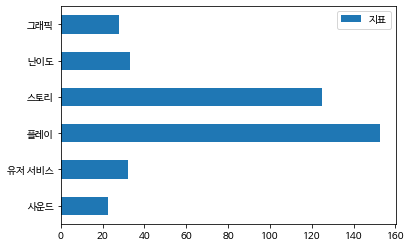

In [ ]:
from matplotlib import pyplot as plt

df_score.plot(kind='barh')

In [ ]:
temp_score = (sound_final_score/len(df_sound)) + (userservice_final_score/len(df_us)) + (play_final_score/len(df_play)) +(story_final_score/len(df_story)) +(graphic_final_score/len(df_graphic))

In [ ]:
num_review = (len(df_sound)+len(df_us)+len(df_story)+len(df_play)+len(df_graphic))

final_score = temp_score * min(num_review/1000 , 1)

In [ ]:
final_score

0.39452646659269164